In [10]:
import psycopg2
import pandas as pd
import numpy as np

# Define the connection parameters
host = 'localhost'
database = 'tellcodb'
user = 'postgres'
password = '1234'

# Establish a connection to the database
try:
    connection = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    cursor = connection.cursor()

    # Fetch the telecom dataset
    query = "SELECT * FROM xdr_data;"
    cursor.execute(query)
    telecom_data = cursor.fetchall()

    # Convert fetched data into a pandas DataFrame
    telecom_df = pd.DataFrame(telecom_data, columns=[desc[0] for desc in cursor.description])

    # Close the cursor and connection
    cursor.close()
    connection.close()

except (Exception, psycopg2.Error) as error:
    print("Error while fetching data from PostgreSQL:", error)

In [12]:
# Check the column names in the DataFrame
print(telecom_df.columns)

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [13]:
# Handle missing values (replace with mean of the corresponding column)
numeric_columns = telecom_df.select_dtypes(include=np.number).columns
telecom_df[numeric_columns] = telecom_df[numeric_columns].fillna(telecom_df[numeric_columns].mean())

# Handle outliers (replace with the mean or median, or remove outliers based on domain knowledge)
# For example, remove outliers in 'Dur. (ms)' column
Q1 = telecom_df['Dur. (ms)'].quantile(0.25)
Q3 = telecom_df['Dur. (ms)'].quantile(0.75)
IQR = Q3 - Q1
telecom_df = telecom_df[(telecom_df['Dur. (ms)'] >= Q1 - 1.5 * IQR) & (telecom_df['Dur. (ms)'] <= Q3 + 1.5 * IQR)]

In [14]:
# Group by user identifier and aggregate the metrics
user_behavior_metrics = telecom_df.groupby('MSISDN/Number').agg({
    'Bearer Id': 'count',  # Number of xDR sessions
    'Dur. (ms)': 'sum',    # Session duration
    'Total DL (Bytes)': 'sum',  # Total download data
    'Total UL (Bytes)': 'sum',  # Total upload data
    'Social Media DL (Bytes)': 'sum',  # Total social media download data
    'Social Media UL (Bytes)': 'sum',  # Total social media upload data
    'Google DL (Bytes)': 'sum',        # Total Google download data
    'Google UL (Bytes)': 'sum',        # Total Google upload data
    'Email DL (Bytes)': 'sum',         # Total email download data
    'Email UL (Bytes)': 'sum',         # Total email upload data
    'Youtube DL (Bytes)': 'sum',       # Total YouTube download data
    'Youtube UL (Bytes)': 'sum',       # Total YouTube upload data
    'Netflix DL (Bytes)': 'sum',       # Total Netflix download data
    'Netflix UL (Bytes)': 'sum',       # Total Netflix upload data
    'Gaming DL (Bytes)': 'sum',        # Total gaming download data
    'Gaming UL (Bytes)': 'sum',        # Total gaming upload data
    'Other DL (Bytes)': 'sum',         # Total other download data
    'Other UL (Bytes)': 'sum'          # Total other upload data
})

# Rename columns for clarity
user_behavior_metrics.columns = ['Num_xDR_sessions', 'Session_duration', 'Total_DL', 'Total_UL',
                                 'Social_Media_DL', 'Social_Media_UL', 'Google_DL', 'Google_UL',
                                 'Email_DL', 'Email_UL', 'Youtube_DL', 'Youtube_UL',
                                 'Netflix_DL', 'Netflix_UL', 'Gaming_DL', 'Gaming_UL',
                                 'Other_DL', 'Other_UL']

# Calculate total data volume for each session for each application
user_behavior_metrics['Total_data_volume_Social_Media'] = user_behavior_metrics['Social_Media_DL'] + user_behavior_metrics['Social_Media_UL']
user_behavior_metrics['Total_data_volume_Google'] = user_behavior_metrics['Google_DL'] + user_behavior_metrics['Google_UL']
user_behavior_metrics['Total_data_volume_Email'] = user_behavior_metrics['Email_DL'] + user_behavior_metrics['Email_UL']
user_behavior_metrics['Total_data_volume_Youtube'] = user_behavior_metrics['Youtube_DL'] + user_behavior_metrics['Youtube_UL']
user_behavior_metrics['Total_data_volume_Netflix'] = user_behavior_metrics['Netflix_DL'] + user_behavior_metrics['Netflix_UL']
user_behavior_metrics['Total_data_volume_Gaming'] = user_behavior_metrics['Gaming_DL'] + user_behavior_metrics['Gaming_UL']
user_behavior_metrics['Total_data_volume_Other'] = user_behavior_metrics['Other_DL'] + user_behavior_metrics['Other_UL']

# Drop the individual application download/upload columns
user_behavior_metrics.drop(columns=['Social_Media_DL', 'Social_Media_UL', 'Google_DL', 'Google_UL',
                                     'Email_DL', 'Email_UL', 'Youtube_DL', 'Youtube_UL',
                                     'Netflix_DL', 'Netflix_UL', 'Gaming_DL', 'Gaming_UL',
                                     'Other_DL', 'Other_UL'], inplace=True)

# Display the aggregated user behavior metrics
user_behavior_metrics.head()

,Num_xDR_sessions,Session_duration,Total_DL,Total_UL,Total_data_volume_Social_Media,Total_data_volume_Google,Total_data_volume_Email,Total_data_volume_Youtube,Total_data_volume_Netflix,Total_data_volume_Gaming,Total_data_volume_Other
MSISDN/Number,,,,,,,,,,,
3.360100e+10,1,116720.0,8.426375e+08,36053108.0,2232135.0,4389005.0,1331362.0,21624548.0,27180981.0,8.124587e+08,386570872.0
3.360100e+10,1,181230.0,1.207552e+08,36104459.0,2660565.0,5334863.0,3307781.0,12432223.0,11221763.0,1.197501e+08,281710071.0
3.360100e+10,1,134969.0,5.566597e+08,39306820.0,3195623.0,3443126.0,3205380.0,21333570.0,19353900.0,5.388277e+08,501693672.0
3.360101e+10,1,49878.0,4.019932e+08,20327526.0,280294.0,9678493.0,2284670.0,6977321.0,1942092.0,3.911261e+08,35279702.0
3.360101e+10,2,37104.0,1.363130e+09,94280527.0,2912542.0,18499616.0,3305469.0,41533002.0,49201724.0,1.314798e+09,804804484.0


In [15]:
# Identify Key Variables and Data Types
print(telecom_df.info())

# Calculate Basic Metrics
numeric_columns = telecom_df.select_dtypes(include=['number']).columns
basic_metrics = telecom_df[numeric_columns].describe()

# Display basic metrics
print(basic_metrics)

<class 'pandas.core.frame.DataFrame'>
Index: 142817 entries, 92 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 142817 non-null  float64
 1   Start                                     142816 non-null  object 
 2   Start ms                                  142817 non-null  float64
 3   End                                       142816 non-null  object 
 4   End ms                                    142817 non-null  float64
 5   Dur. (ms)                                 142817 non-null  float64
 6   IMSI                                      142817 non-null  float64
 7   MSISDN/Number                             142817 non-null  float64
 8   IMEI                                      142817 non-null  float64
 9   Last Location Name                        141687 non-null  object 
 10  Avg RTT DL (ms)         

In [16]:
# Compute Dispersion Parameters
dispersion_parameters = telecom_df[numeric_columns].agg(['mean', 'median', 'std', 'min', 'max', 'var'])
# Additional dispersion parameters such as range, quartiles, etc., can also be calculated if needed.

# Interpretation
# Display computed dispersion parameters
print(dispersion_parameters)

           Bearer Id      Start ms        End ms     Dur. (ms)          IMSI  \
mean    1.013514e+19    499.180449    498.843505  9.226122e+04  2.082017e+14   
median  7.349883e+18    499.000000    500.000000  8.639900e+04  2.082015e+14   
std     2.883923e+18    288.687911    288.151335  5.050268e+04  1.559564e+10   
min     6.917538e+18      0.000000      0.000000  7.142000e+03  2.082001e+14   
max     1.318654e+19    999.000000    999.000000  2.449000e+05  2.140743e+14   
var     8.317010e+36  83340.710177  83031.192040  2.550521e+09  2.432238e+20   

        MSISDN/Number          IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
mean     3.373386e+10  4.871054e+13       111.180447        17.673731   
median   3.366378e+10  3.572821e+13        54.000000         7.000000   
std      6.966809e+08  2.251614e+13       567.534377        76.375396   
min      3.360100e+10  4.400152e+11         0.000000         0.000000   
max      4.188282e+10  9.900120e+13     96923.000000      7120.000000   
v

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


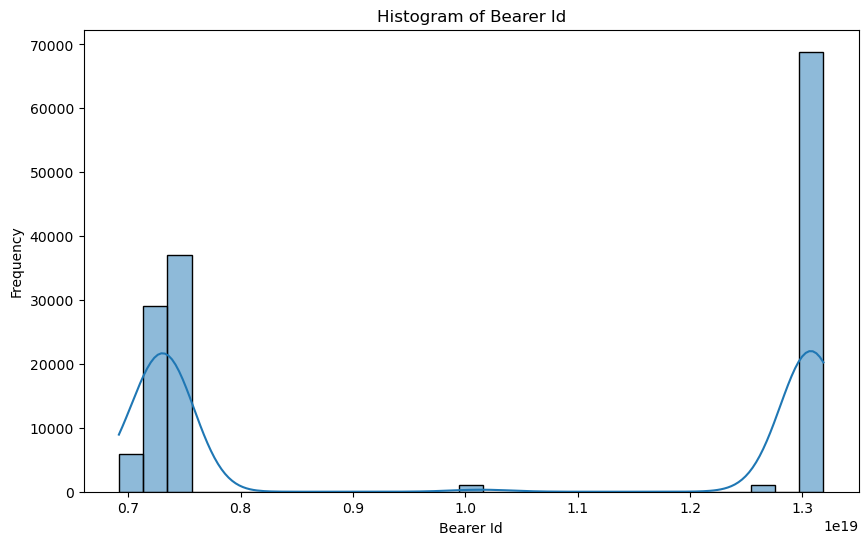

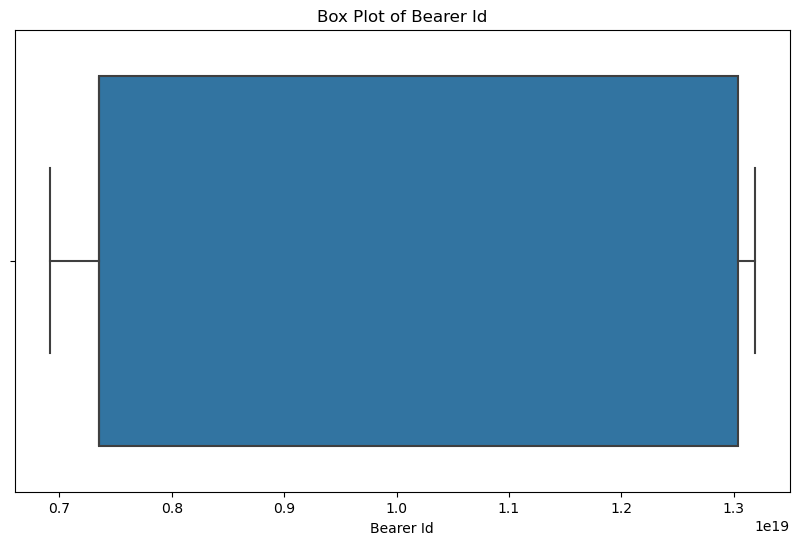

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


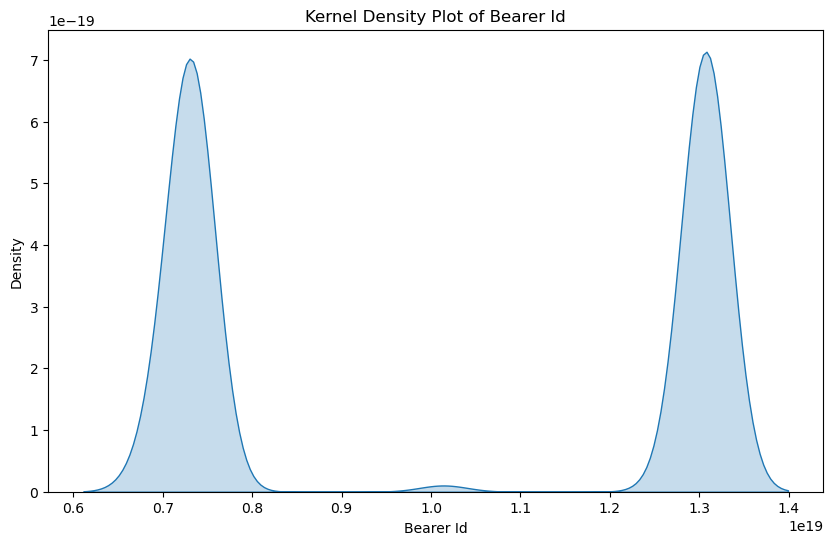

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


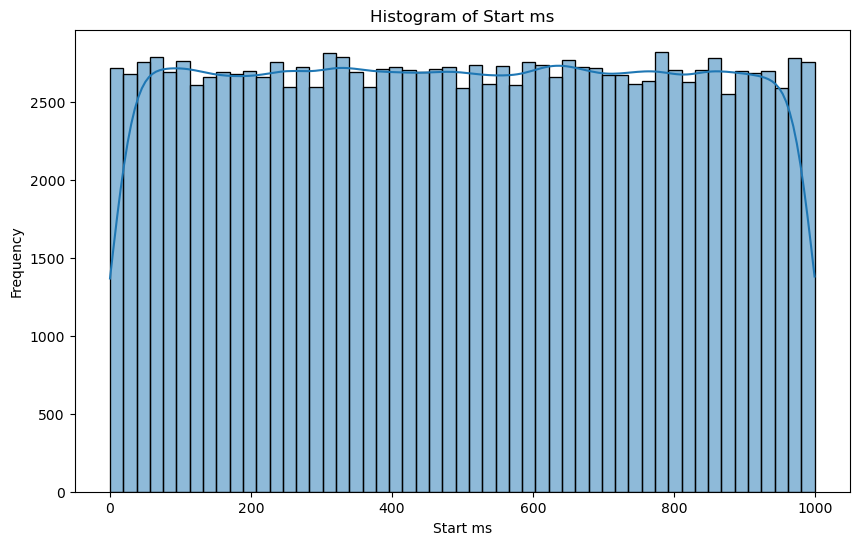

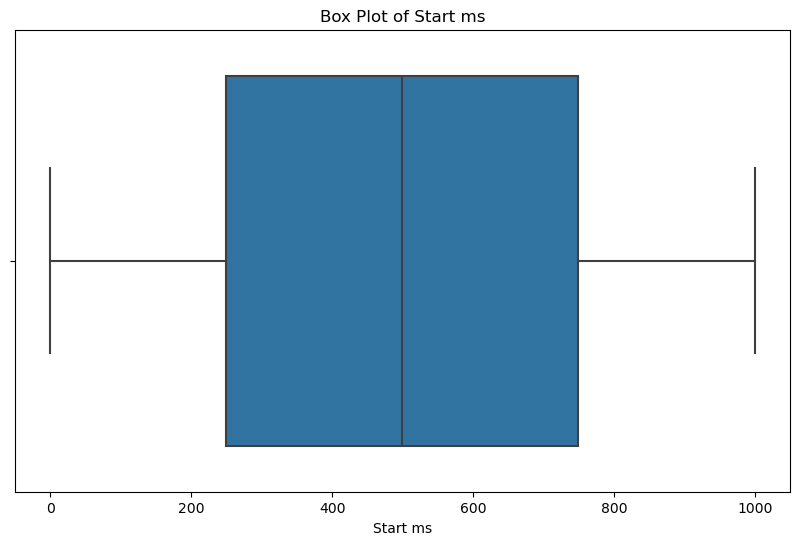

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


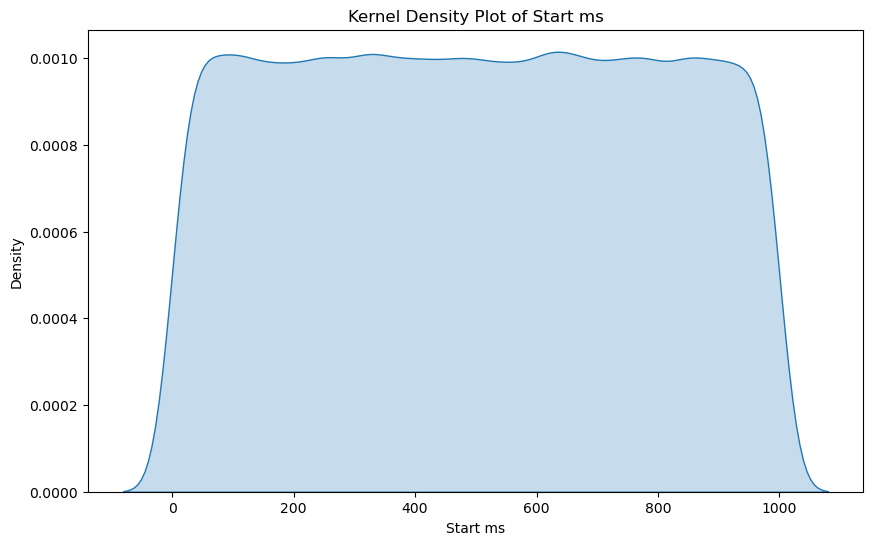

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


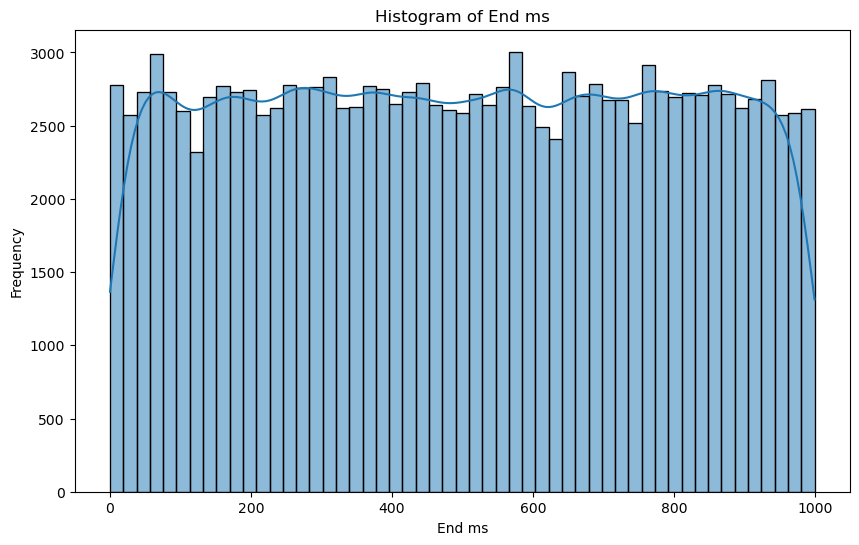

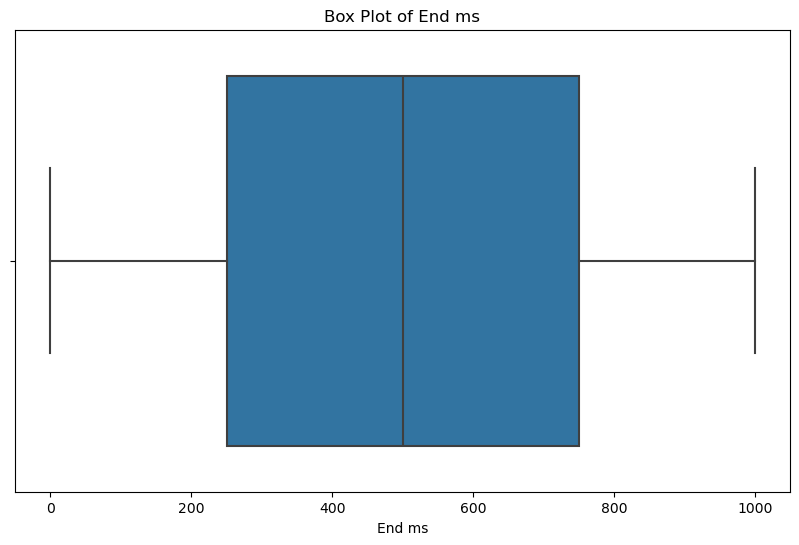

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


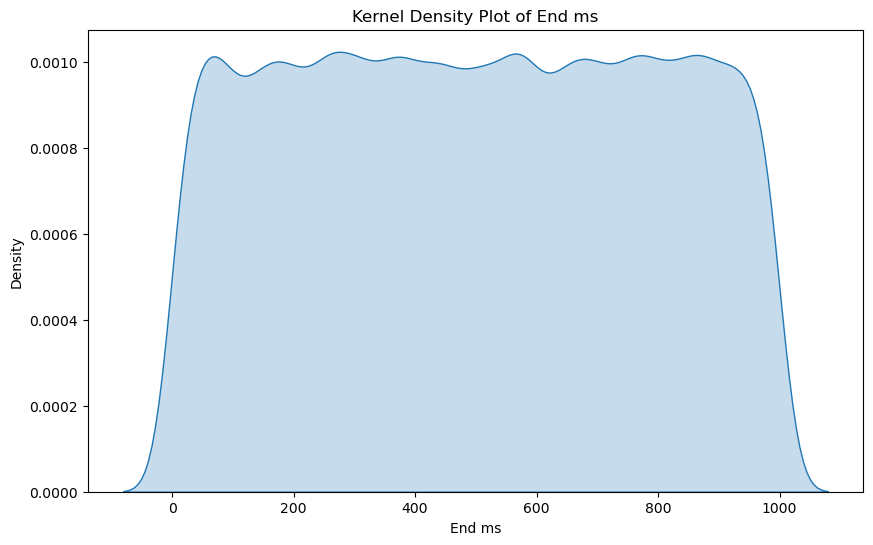

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


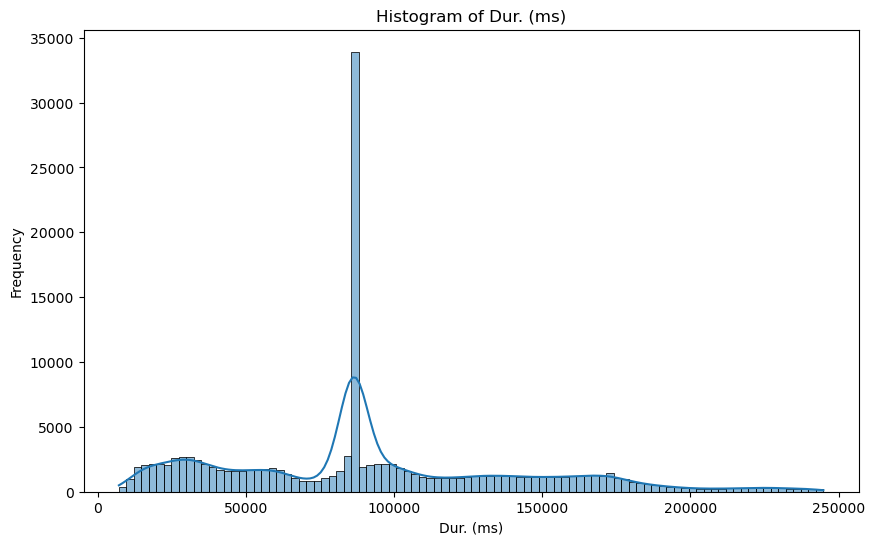

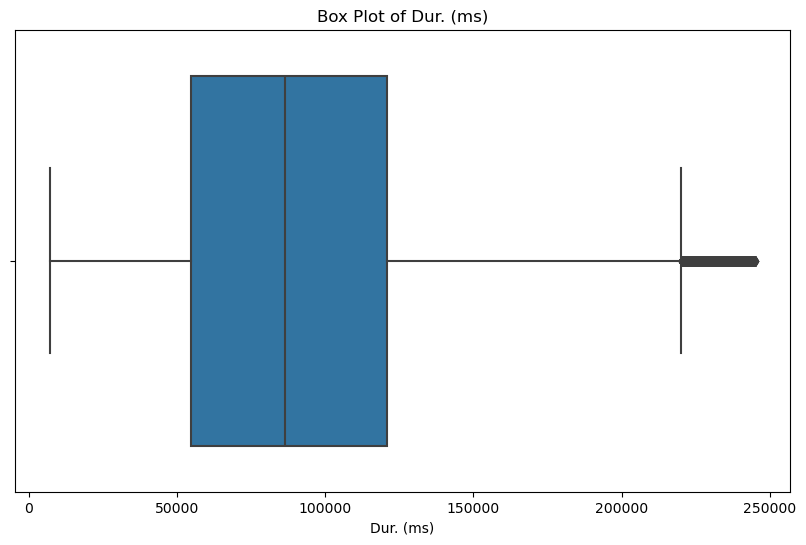

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


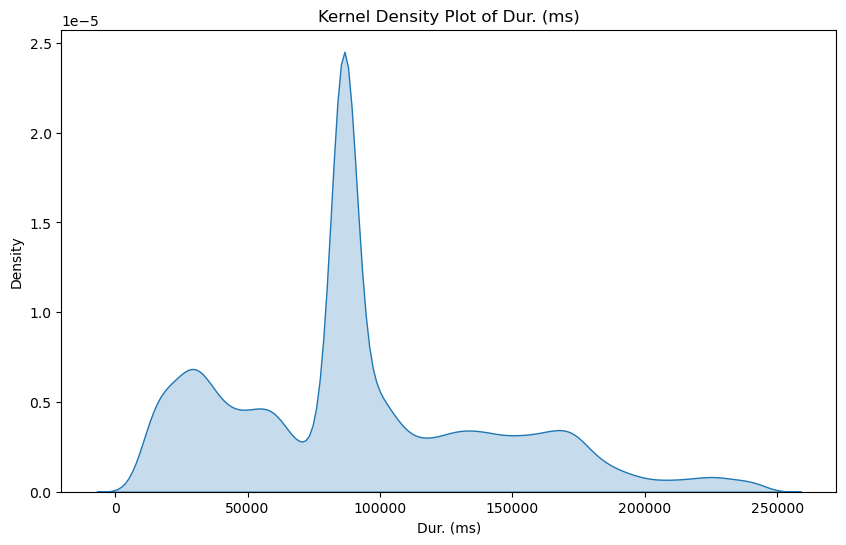

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KeyboardInterrupt: 

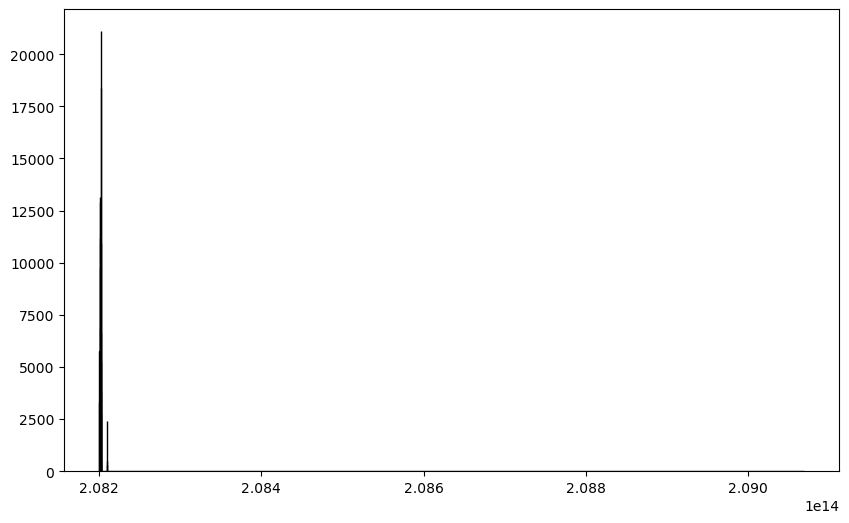

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical and categorical columns
numerical_columns = telecom_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = telecom_df.select_dtypes(include=['object']).columns.tolist()



# Numerical Variables
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=telecom_df, x=column, kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=telecom_df, x=column)
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=telecom_df, x=column, fill=True)
    plt.title(f'Kernel Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()

# Categorical Variables
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=telecom_df, x=column)
    plt.title(f'Bar Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(8, 8))
    telecom_df[column].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title(f'Pie Chart of {column}')
    plt.ylabel('')
    plt.show()

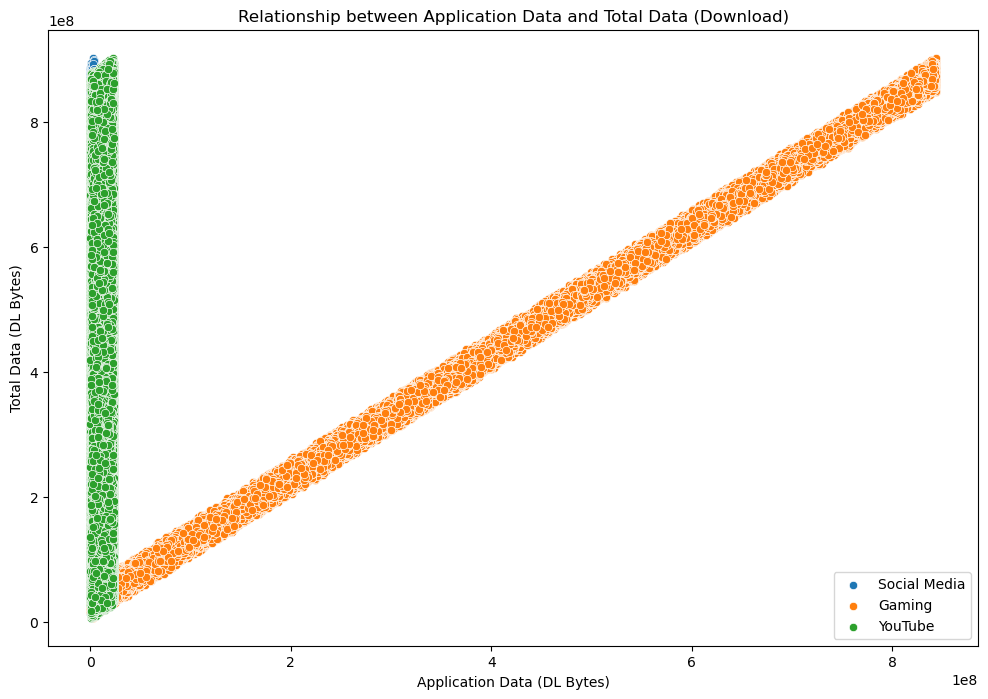

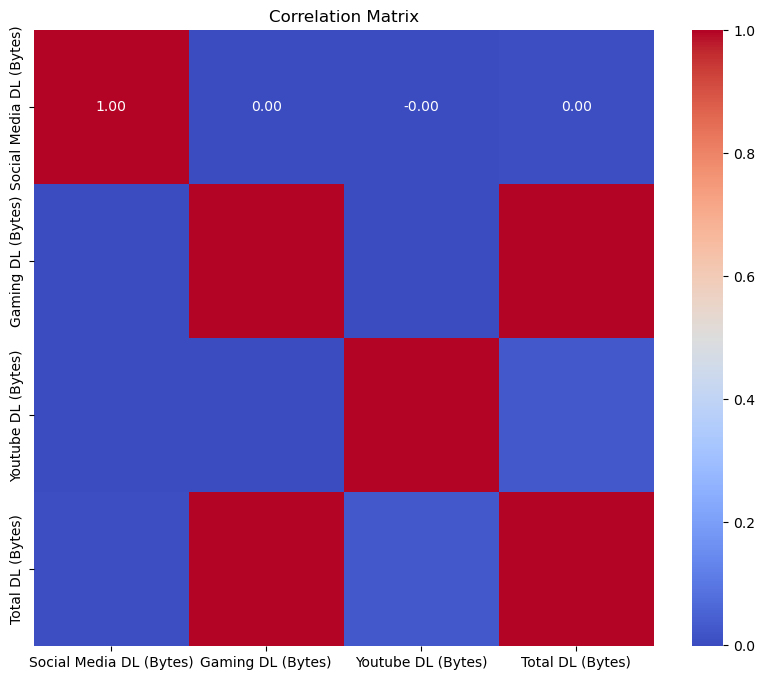

In [22]:
# Scatter plots
plt.figure(figsize=(12, 8))
sns.scatterplot(data=telecom_df, x='Social Media DL (Bytes)', y='Total DL (Bytes)', label='Social Media')
sns.scatterplot(data=telecom_df, x='Gaming DL (Bytes)', y='Total DL (Bytes)', label='Gaming')
sns.scatterplot(data=telecom_df, x='Youtube DL (Bytes)', y='Total DL (Bytes)', label='YouTube')
plt.xlabel('Application Data (DL Bytes)')
plt.ylabel('Total Data (DL Bytes)')
plt.title('Relationship between Application Data and Total Data (Download)')
plt.legend()
plt.show()

# Correlation matrix
correlation_matrix = telecom_df[['Social Media DL (Bytes)', 'Gaming DL (Bytes)', 'Youtube DL (Bytes)', 'Total DL (Bytes)']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

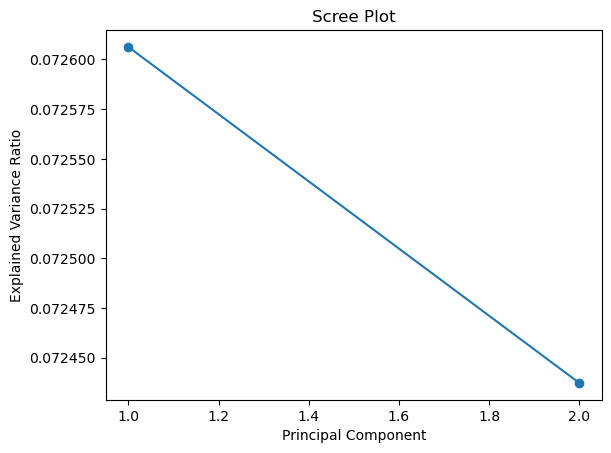

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Variable Transformations - Decile Classes
# Calculate total session duration
telecom_df['Total Session Duration'] = telecom_df['Dur. (ms)'] * telecom_df['DL TP > 1 Mbps (%)']
# Segment users into decile classes based on total session duration
telecom_df['Decile Class'] = pd.qcut(telecom_df['Total Session Duration'], q=10, labels=False, duplicates='drop')
# Compute total data (DL+UL) for each decile class
decile_data_usage = telecom_df.groupby('Decile Class')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum()

# Correlation Analysis - Correlation Matrix
# Specify variables for correlation analysis
correlation_variables = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Social Media UL (Bytes)',
                         'Google UL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                         'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
                         'Other DL (Bytes)', 'Other UL (Bytes)']
# Compute correlation matrix
correlation_matrix = telecom_df[correlation_variables].corr()

# Dimensionality Reduction - Principal Component Analysis (PCA)
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(telecom_df[correlation_variables])
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
# Scree plot
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [33]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [31]:
# Aggregate engagement metrics per customer ID (MSISDN)
engagement_metrics = telecom_df.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',  # Total session duration
    'Total DL (Bytes)': 'sum',  # Total download data
    'Total UL (Bytes)': 'sum'   # Total upload data
}).reset_index()

# Report the top 10 customers per engagement metric
top_10_duration = engagement_metrics.sort_values('Dur. (ms)', ascending=False).head(10)
top_10_dl = engagement_metrics.sort_values('Total DL (Bytes)', ascending=False).head(10)
top_10_ul = engagement_metrics.sort_values('Total UL (Bytes)', ascending=False).head(10)

print("Top 10 customers by session duration:")
print(top_10_duration)
print("\nTop 10 customers by total download data:")
print(top_10_dl)
print("\nTop 10 customers by total upload data:")
print(top_10_ul)

# Normalize each engagement metric
scaler = StandardScaler()
engagement_metrics_normalized = scaler.fit_transform(engagement_metrics.iloc[:, 1:])

# Run k-means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=0)
engagement_clusters = kmeans.fit_predict(engagement_metrics_normalized)

# Add cluster labels to the dataframe
engagement_metrics['Cluster'] = engagement_clusters

# Compute non-normalized metrics for each cluster
cluster_metrics = engagement_metrics.groupby('Cluster').agg({
    'Dur. (ms)': ['min', 'max', 'mean', 'sum'],
    'Total DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Total UL (Bytes)': ['min', 'max', 'mean', 'sum']
})

print("\nCluster metrics:")
print(cluster_metrics)

Top 10 customers by session duration:
        MSISDN/Number     Dur. (ms)  Total DL (Bytes)  Total UL (Bytes)
103647   4.188282e+10  6.129978e+07      4.706528e+11      4.297149e+10
34490    3.365936e+10  1.402398e+06      3.041347e+09      2.690319e+08
1596     3.360658e+10  1.322251e+06      4.380586e+09      3.508812e+08
20652    3.364618e+10  1.249844e+06      3.461601e+09      3.560257e+08
90400    3.376062e+10  1.139614e+06      3.795262e+09      2.336841e+08
87826    3.375049e+10  1.137828e+06      2.541706e+09      2.261905e+08
36808    3.365991e+10  1.066275e+06      2.279067e+09      2.876160e+08
32046    3.365883e+10  1.056861e+06      3.147020e+09      2.884391e+08
95607    3.376276e+10  1.054344e+06      2.789523e+09      2.553219e+08
48715    3.366279e+10  1.046626e+06      2.522510e+09      2.521422e+08

Top 10 customers by total download data:
        MSISDN/Number     Dur. (ms)  Total DL (Bytes)  Total UL (Bytes)
103647   4.188282e+10  6.129978e+07      4.706528e+11   

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster metrics:
            Dur. (ms)                                            \
                  min           max          mean           sum   
Cluster                                                           
0        7.142000e+03  2.664610e+05  9.891741e+04  8.873881e+09   
1        6.129978e+07  6.129978e+07  6.129978e+07  6.129978e+07   
2        6.659400e+04  1.402398e+06  3.043187e+05  4.241290e+09   

        Total DL (Bytes)                                            \
                     min           max          mean           sum   
Cluster                                                              
0           8.827082e+06  1.992887e+09  5.160096e+08  4.629122e+13   
1           4.706528e+11  4.706528e+11  4.706528e+11  4.706528e+11   
2           6.527075e+07  4.765821e+09  1.304926e+09  1.818676e+13   

        Total UL (Bytes)                                            
                     min           max          mean           sum  
Cluster             

C:\Users\User\AppData\Local\Temp\ipykernel_31472\248945896.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_traffic['MSISDN/Number'] = telecom_df['MSISDN/Number'].copy()  # Use .copy() to avoid SettingWithCopyWarning


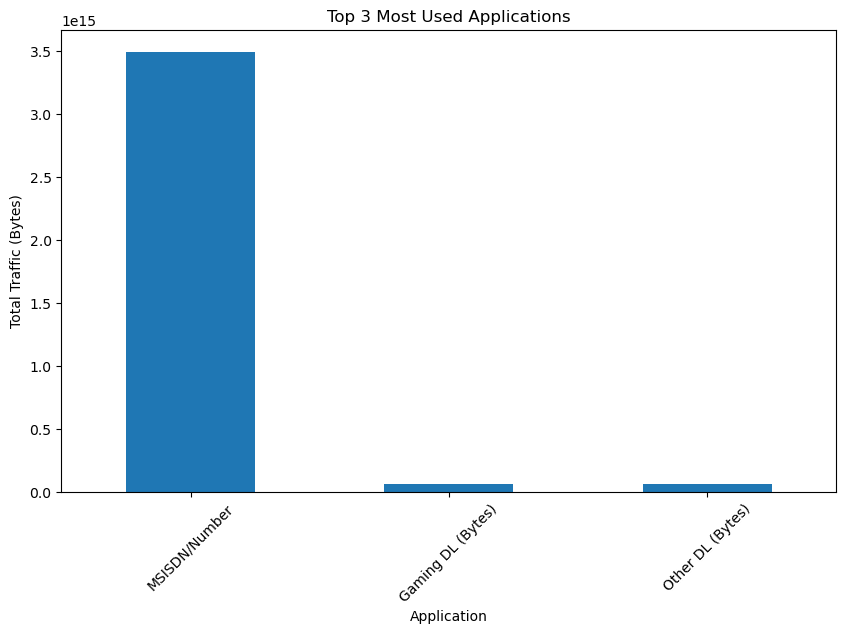

In [ ]:
# Aggregate user total traffic per application
app_columns = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']
app_traffic = telecom_df[[f'{app} DL (Bytes)' for app in app_columns] + [f'{app} UL (Bytes)' for app in app_columns]]
app_traffic['MSISDN/Number'] = telecom_df['MSISDN/Number'].copy()  # Use .copy() to avoid SettingWithCopyWarning
user_app_traffic = app_traffic.groupby('MSISDN/Number').sum().reset_index()

# Derive the top 10 most engaged users per application
top_10_users_per_app = {}
for app in app_columns:
    top_10_users_per_app[app] = user_app_traffic.sort_values(f'{app} DL (Bytes)', ascending=False).head(10)

# Plot the top 3 most used applications
top_3_apps = user_app_traffic.sum().nlargest(3).index.tolist()
top_3_apps_traffic = user_app_traffic[top_3_apps]

plt.figure(figsize=(10, 6))
top_3_apps_traffic.sum().plot(kind='bar')
plt.title('Top 3 Most Used Applications')
plt.xlabel('Application')
plt.ylabel('Total Traffic (Bytes)')
plt.xticks(rotation=45)
plt.show()

# Determine the optimized value of k using the elbow method for k-means clustering
scaler = StandardScaler()
user_app_traffic_normalized = scaler.fit_transform(user_app_traffic.drop('MSISDN/Number', axis=1))

k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)  # Explicitly set n_init to suppress future warning
    cluster_labels = kmeans.fit_predict(user_app_traffic_normalized)
    silhouette_scores.append(silhouette_score(user_app_traffic_normalized, cluster_labels))

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.show()